In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/direct.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/f')

In [2]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [3]:

# Set random seed pour le meme repetition
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

Random Seed:  999


In [4]:
# chemin du dossier
dataroot = "/content/f/direct"

# Nomber de workers du dataloader
workers = 2

# Batch size
batch_size = 128


# size d'image
image_size = 64

# Nombre de channels j'ai utiliser les channels de couleur pour une bon image generer
nc = 3 #bedelt hna 3 b 1

# Size de bruit z (la meme que de generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate de l'optimizateur
lr = 0.0002

# Beta1 hyperparameter de l'optimizateur Adam
beta1 = 0.5

# Number of GPUs available.
ngpu = 1
# numbre des epoch
num_epochs = 5


In [5]:
# Creation du dataset
dataset = dset.ImageFolder(dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Create de dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [8]:
# Decition du device d'execution
device = torch.device("cpu")

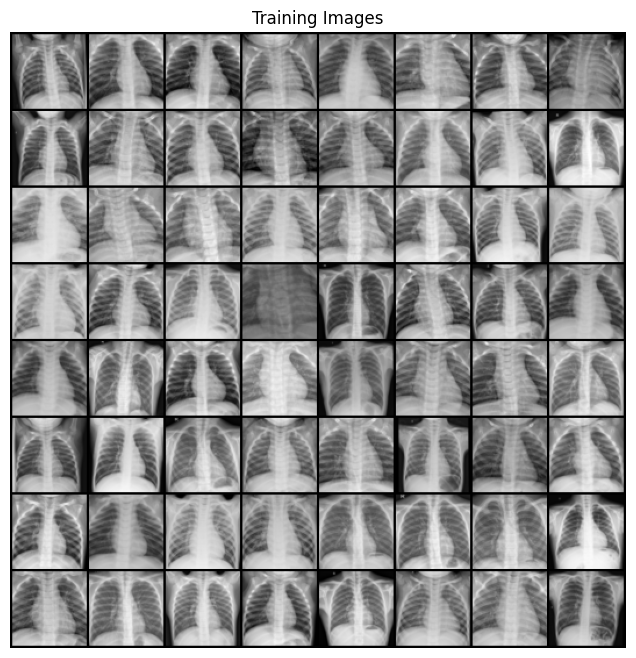

In [9]:
# Ploter des exemples des images d'entrainement
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [10]:
# Initialisation des poids d'entrainement (weights)
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Creation du generator
netG = Generator(ngpu).to(device)

# device gpu
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Application des poids initiaux au generator
netG.apply(weights_init)

# Print le model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [13]:
# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, input):
        return self.main(input)



In [14]:
# Creation du Discriminator
netD = Discriminator(ngpu).to(device)

# device gpu
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Application des poids initiaux au discriminator
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
# initialisation du fonction d'erreur (Loss)
criterion = nn.BCELoss()

In [16]:
# Creation de  batch du vecteur pour la visualisation
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [17]:
# etablisement de labels (y=1 pour les images reele et y=0 pour les fake images)
real_label = 1.
fake_label = 0.

In [18]:
# definir les optimizateur
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
netD=torch.load('/content/netDnormalefinal.pt.pt')
netG=torch.load('/content/netGnormalefinal.pt')

In [24]:
# Training Loop
# Liste pour visualiser la progression
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For pour les epochs
for epoch in range(1000):
    # For pour chaque batch du dataloader
    for i, data in enumerate(dataloader, 0):

        #D  maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Ensure that the input and weight types are the same


# Rest of the code remains the same
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        # G maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output de statistique du training
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/2]	Loss_D: 0.0100	Loss_G: 5.6598	D(x): 0.9950	D(G(z)): 0.0049 / 0.0049
[1/5][0/2]	Loss_D: 0.0199	Loss_G: 5.7782	D(x): 0.9850	D(G(z)): 0.0046 / 0.0046
[2/5][0/2]	Loss_D: 0.0189	Loss_G: 5.8811	D(x): 0.9853	D(G(z)): 0.0039 / 0.0039
[3/5][0/2]	Loss_D: 0.0206	Loss_G: 5.9167	D(x): 0.9839	D(G(z)): 0.0041 / 0.0041
[4/5][0/2]	Loss_D: 0.0220	Loss_G: 5.7257	D(x): 0.9828	D(G(z)): 0.0043 / 0.0043
[5/5][0/2]	Loss_D: 0.0099	Loss_G: 5.8000	D(x): 0.9947	D(G(z)): 0.0045 / 0.0045
[6/5][0/2]	Loss_D: 0.0114	Loss_G: 5.3848	D(x): 0.9949	D(G(z)): 0.0062 / 0.0062
[7/5][0/2]	Loss_D: 0.0214	Loss_G: 5.6490	D(x): 0.9841	D(G(z)): 0.0052 / 0.0052
[8/5][0/2]	Loss_D: 0.0109	Loss_G: 5.5558	D(x): 0.9950	D(G(z)): 0.0058 / 0.0058
[9/5][0/2]	Loss_D: 0.0204	Loss_G: 5.2817	D(x): 0.9864	D(G(z)): 0.0066 / 0.0066
[10/5][0/2]	Loss_D: 0.0129	Loss_G: 5.5591	D(x): 0.9927	D(G(z)): 0.0055 / 0.0055
[11/5][0/2]	Loss_D: 0.0246	Loss_G: 5.8816	D(x): 0.9798	D(G(z)): 0.0038 / 0.0038
[12/5][0/2]	Loss_D: 0.01

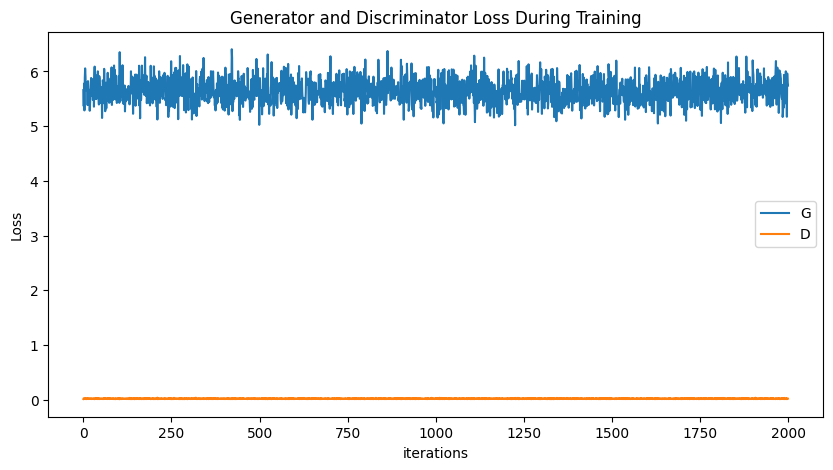

In [25]:
#resultat
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

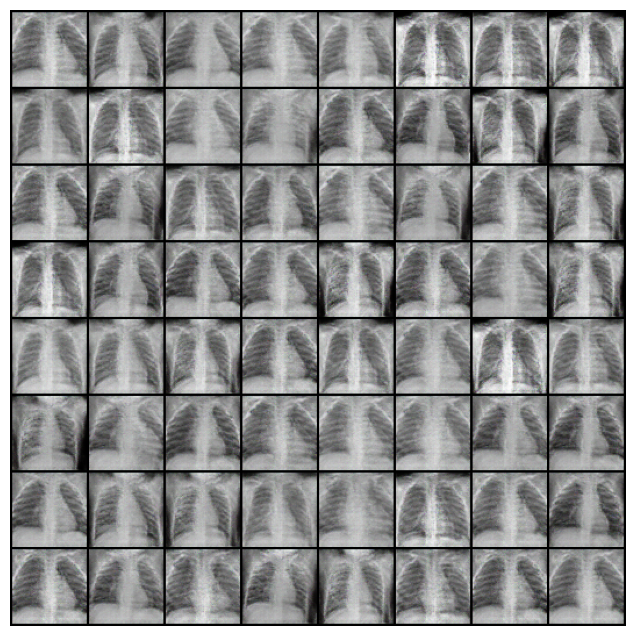

In [26]:
# **Visualization de progression de G

#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

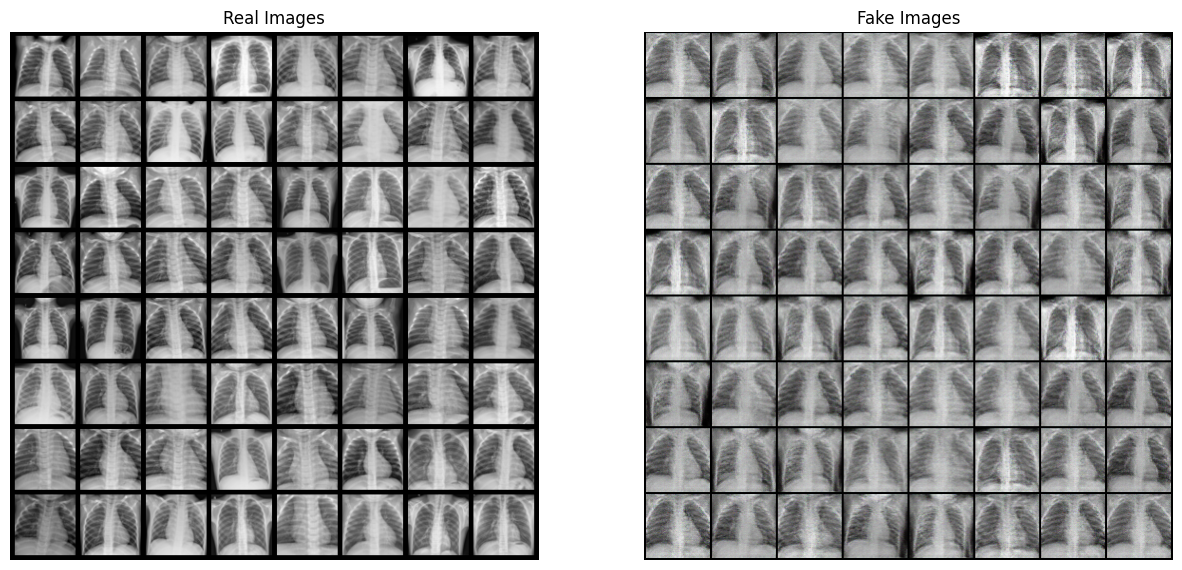

In [27]:
# Prener a batch des images reeles de  dataloader
real_batch = next(iter(dataloader))

# Plot les images reele
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot les fake images de l'epoch derniere
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()


In [28]:
torch.save(netD,'/content/netDnormalefinal.pt')
torch.save(netG,'/content/netGnormalefinal.pt')

In [29]:
torch.save(netD.state_dict(), '/content/netDnormalefinaldict.pth')
torch.save(netG.state_dict(), '/content/netGnormalefinaldict.pth')

In [1]:
import torch
import os
from torchvision.utils import save_image

# Function to generate and save images
def generate_and_save_images(generator, num_images, output_dir):
    # Use a single label "Normal"
    label = "Normal"

    # Create output directory for the label if it doesn't exist
    label_dir = os.path.join(output_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Generate fake images
    with torch.no_grad():
        # Set generator to evaluation mode
        generator.eval()

        # Define the noise dimension and device (assumed to be defined elsewhere in your actual code)
        nz = 100  # Example noise dimension, replace with actual
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Generate random noise
        fixed_noise = torch.randn(num_images, nz, 1, 1, device=device)

        # Generate images from noise
        fake_images = generator(fixed_noise).detach().cpu()

    # Save generated images to disk
    for i in range(num_images):
        # Construct file name
        image_filename = os.path.join(label_dir, f'{label}_{i}.jpg')

        # Save image
        save_image(fake_images[i], image_filename)

# Example usage
if __name__ == '__main__':
    # Example parameters
    num_images = 100
    output_directory = '/content/file'
    generator = netG  # Replace netG with your actual generator model

    # Generate and save images under the "Normal" label
    generate_and_save_images(generator, num_images, output_directory)


NameError: name 'netG' is not defined

In [ ]:
import zipfile
import os

def folder_to_zip(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through each file and subdirectory in the folder
        for root, _, files in os.walk(folder_path):
            # Iterate over each file in the current directory
            for file in files:
                # Construct the full path of the file
                file_path = os.path.join(root, file)
                # Calculate the relative path of the file from the folder
                relative_path = os.path.relpath(file_path, folder_path)
                # Add the file to the zip file with its relative path
                zipf.write(file_path, arcname=relative_path)

# Example usage:
folder_path = '/content/file'
zip_path = '/content/zipfilenormale.zip'

folder_to_zip(folder_path, zip_path)